<a href="https://colab.research.google.com/github/casblood18/Painting-3D-Game-Objects-Using-Generative-AI/blob/main/Update%20Generated%20Mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dependencies


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
# ==================
# install Diffusers
# ==================
!source '/content/drive/My Drive/dev/colab_env/bin/activate'
!pip install accelerate
!pip install "git+https://github.com/huggingface/diffusers"

# ==================
# install OpenCV
# ==================
!pip install opencv-python

In [ ]:
import cv2
import pytorch3d
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, save_obj

# Week 4 Dependencies
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesUV,
    TexturesVertex
)

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

##Part2

In [26]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  torch.cuda.set_device(device)
else:
  device = torch.device("cpu")

# Set paths
obj_filename = "/content/drive/MyDrive/Colab Notebooks/Project_1/cow/cow.obj"

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# Get the obj values
verts, face, aux = load_obj("/content/drive/MyDrive/Colab Notebooks/Project_1/cow/cow.obj")
faces_uvs = face.textures_idx.to(device)
verts_uvs = aux.verts_uvs.to(device)

In [27]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction.
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow.
R, T = look_at_view_transform(2.7, 0, 225)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(
  image_size=512,
  blur_radius=0.0,
  faces_per_pixel=1,
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the
# -z direction.
lights = PointLights(device=device, location=[[90.0, 0.0, 0.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will
# interpolate the texture uv coordinates for each vertex, sample from a texture image and
# apply the Phong lighting model
renderer = MeshRenderer(
  rasterizer=MeshRasterizer(
    cameras=cameras,
    raster_settings=raster_settings
  ),
  shader=SoftPhongShader(
    device=device,
    cameras=cameras,
    lights=lights
  )
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

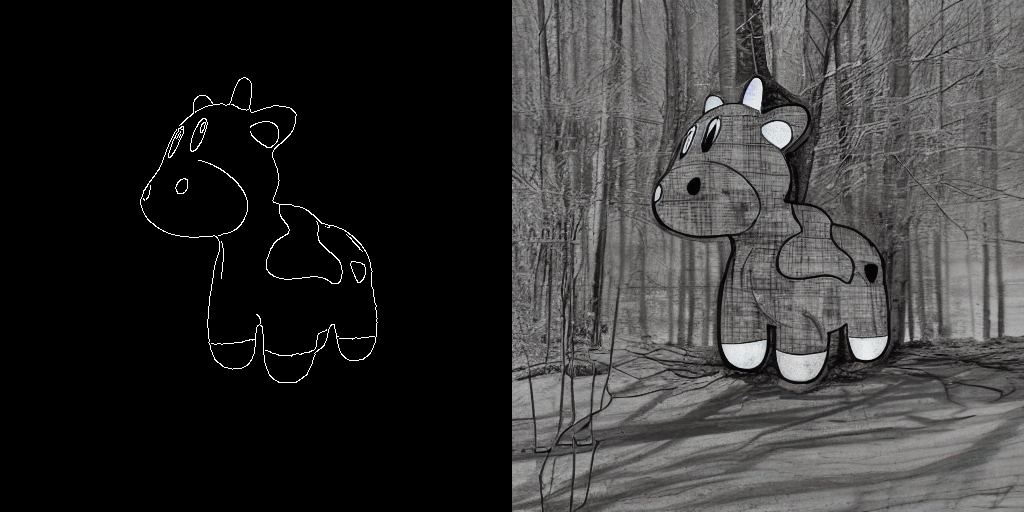

In [29]:
from diffusers.utils import load_image, make_image_grid
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from PIL import Image
import cv2
import numpy as np

#rendered the image and format it to be passable through the controlnet pipeline
rendered_image = renderer(mesh)
image = rendered_image[0, ..., :3].detach().cpu().numpy()
image = image*255
image = image.astype(np.uint8)
image = image.squeeze()
image = image[:, :, :3]
low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

#ControlNet Pipeline
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16, use_safetensors=True)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

#Prompt to pass through pipeline with the canny model
output = pipe(
    "tree", image=canny_image
).images[0]

#visualize the Canny outline and the ControlNet output image
make_image_grid([canny_image, output], rows=1, cols=2)

In [30]:
from PIL import Image
from torchvision import transforms

# getting the learnable tensor for the cow texture map
target = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Project_1/cow/cow_texture.png")
target = target.astype(np.float32)
target = torch.from_numpy(target/255.0).to(device)
verts_rgb = torch.ones(target.shape, device=device, requires_grad=True)

# Format the Image from the ControlNet output
target_rgb = transforms.ToTensor()(output)
target_rgb = target_rgb.unsqueeze(0)
target_rgb = target_rgb.permute(0, 2, 3, 1)
target_rgb = target_rgb[...,:3]

# Check if GPU is available
if torch.cuda.is_available():
  # Set tensor to GPU
  target_rgb = target_rgb.to('cuda')

# Show a visualization comparing the rendered predicted mesh to the ground truth mesh
def visualize_prediction(predicted_mesh, renderer=renderer,
                         target_image=verts_rgb, title='',
                         silhouette=False):
  with torch.no_grad():
    #Render the current i
    predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ...,:3].cpu().detach().numpy())

    #Visualize the verts_rgb image map
    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

In [31]:
# Number of optimization steps
Niter = 20000

# Plot period for the losses
plot_period = 2000

# The optimizer
optimizer = torch.optim.SGD([verts_rgb], lr=100.0, momentum=0.9)

  0%|          | 0/20000 [00:00<?, ?it/s]

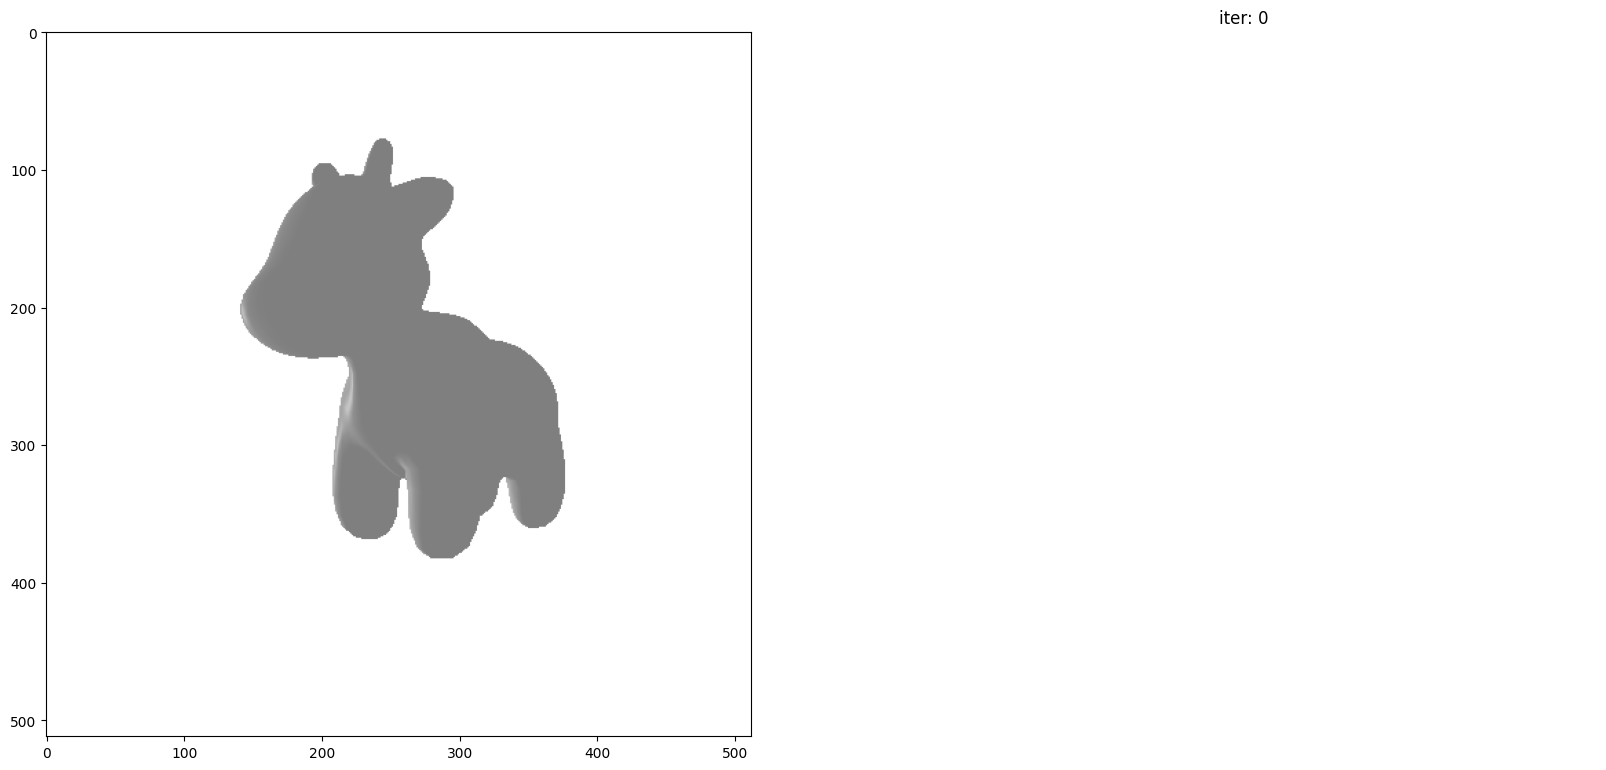

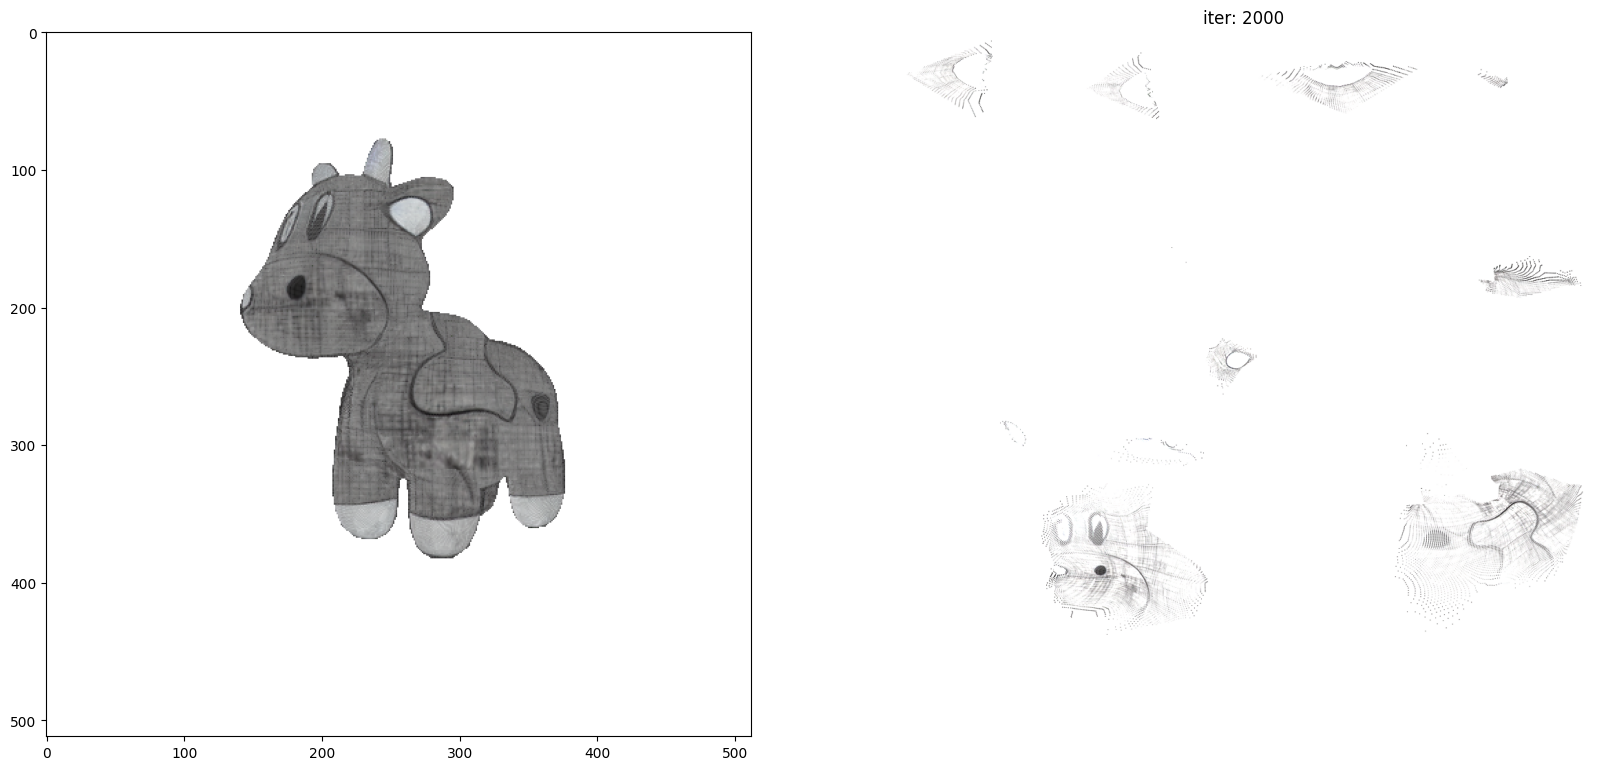

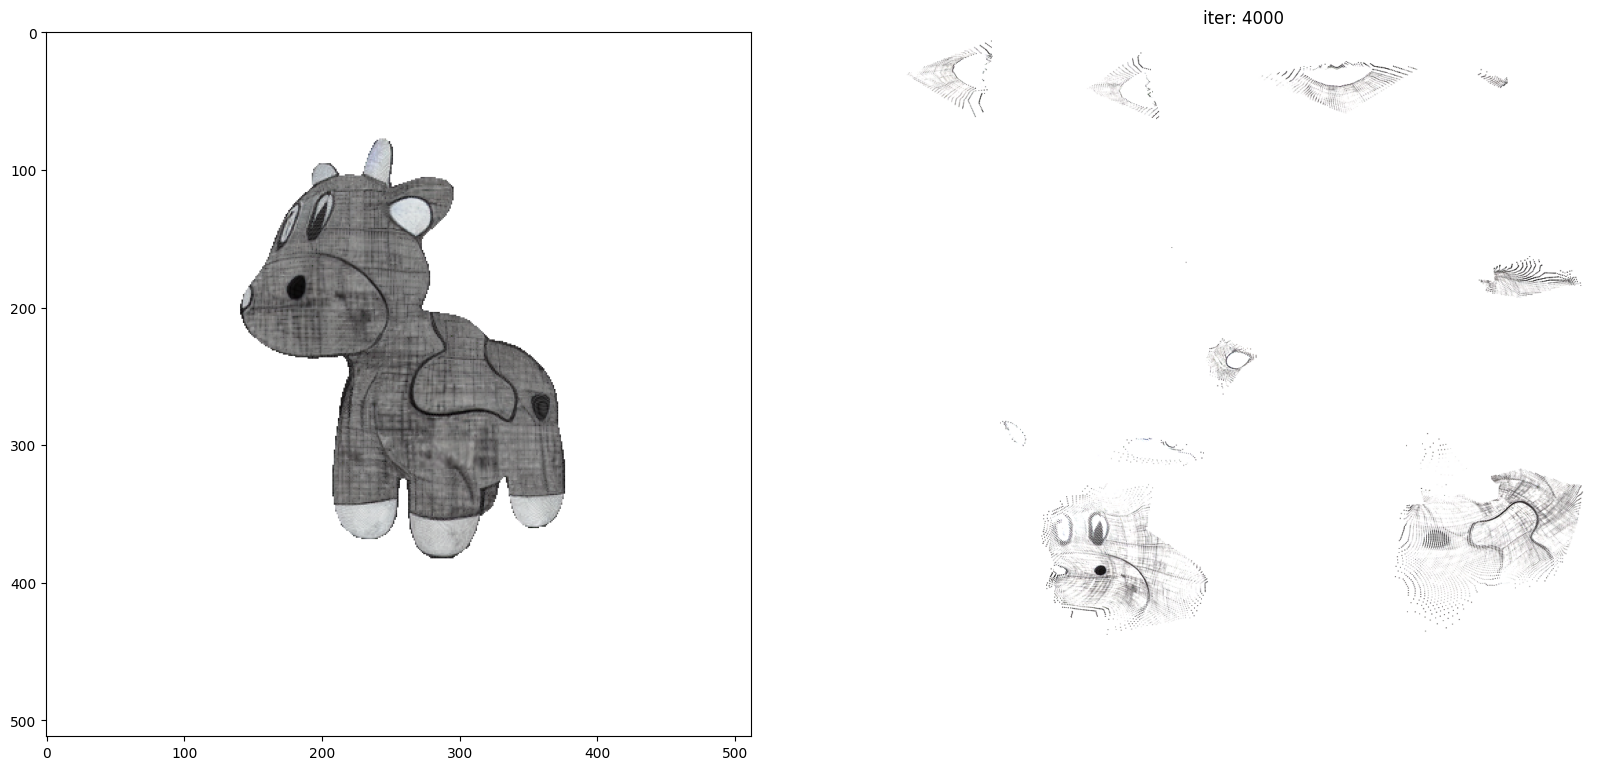

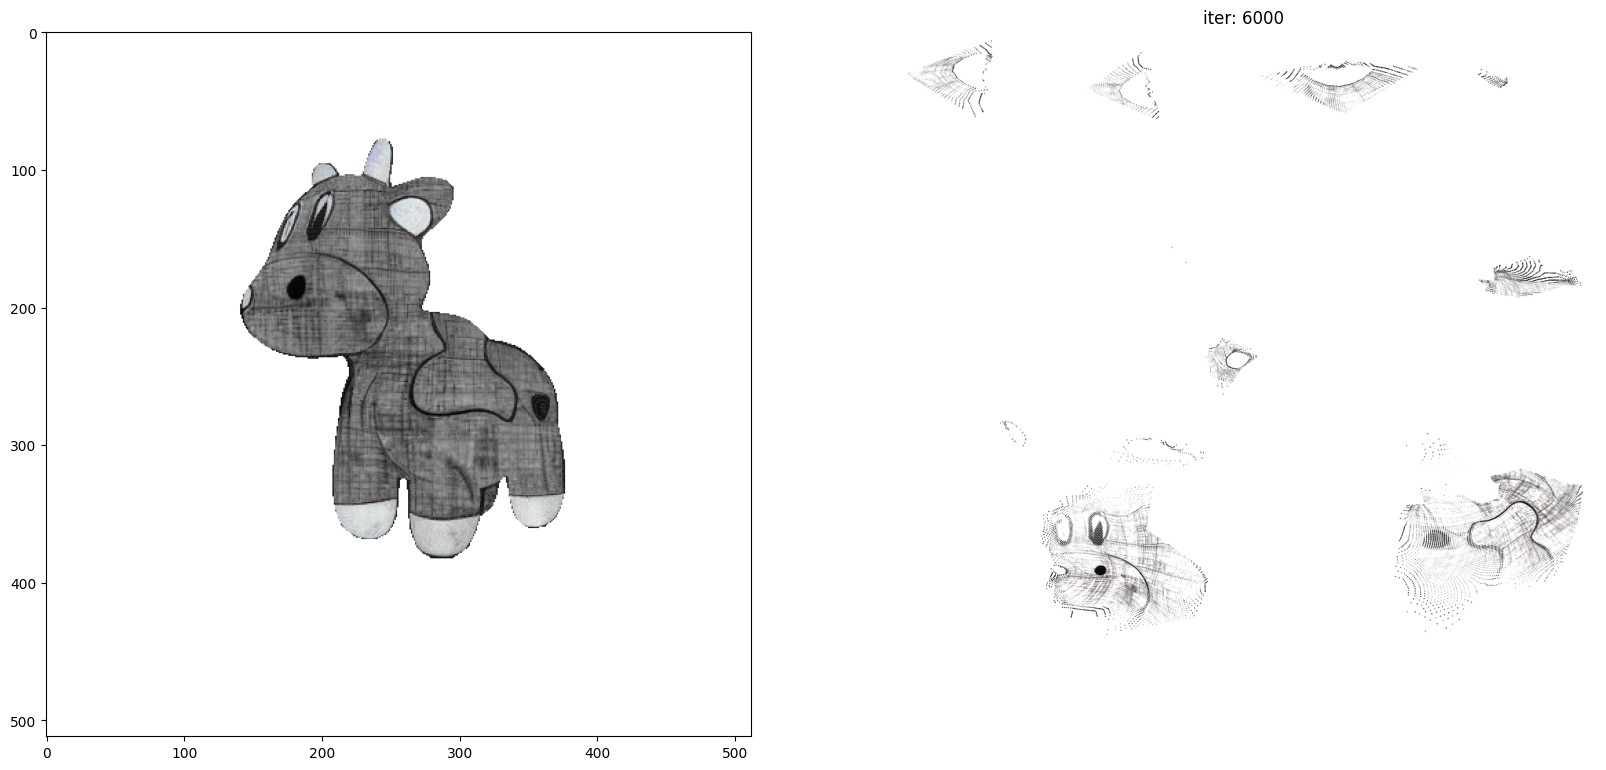

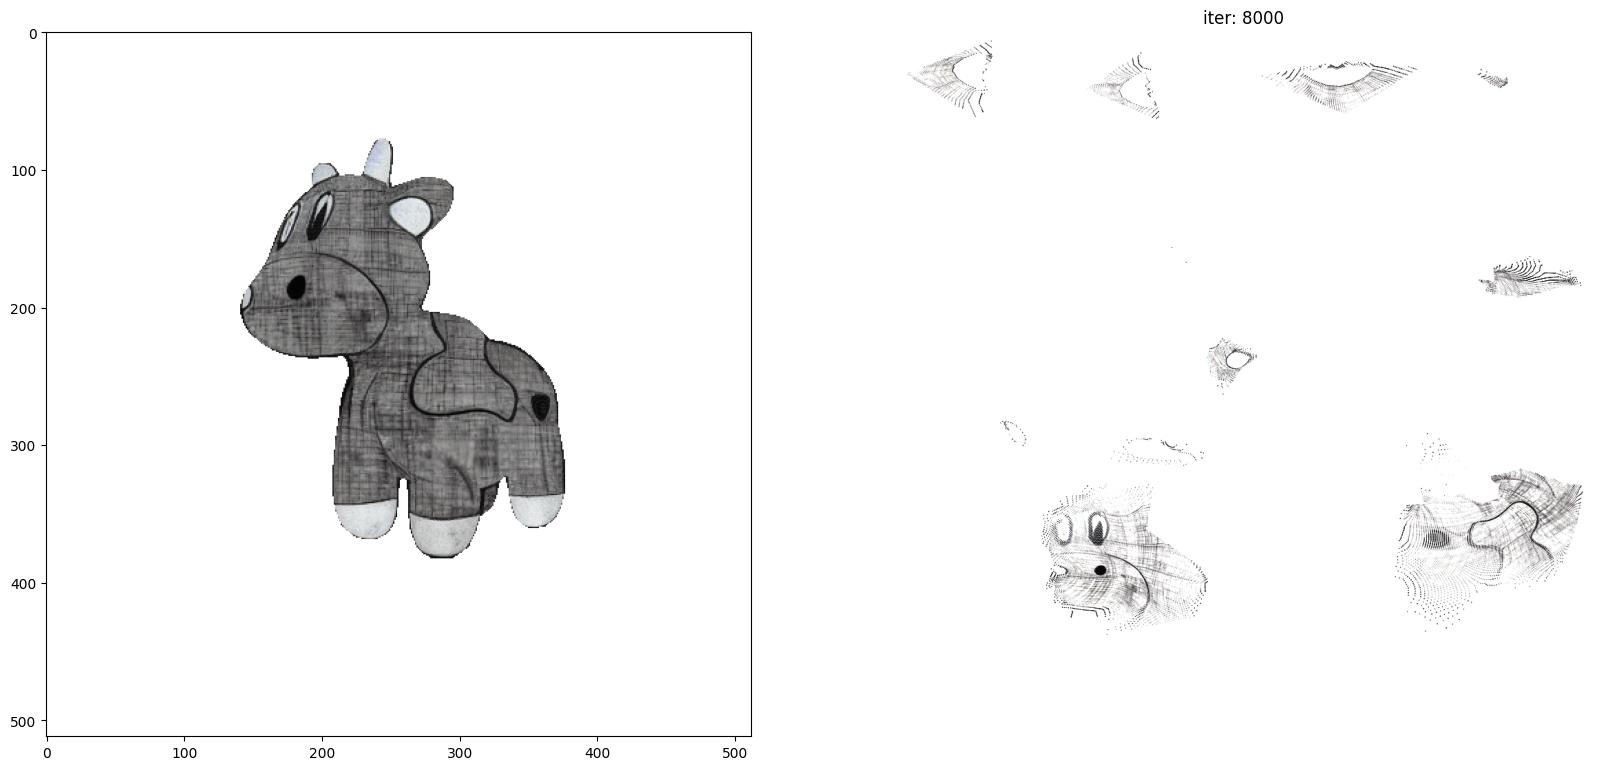

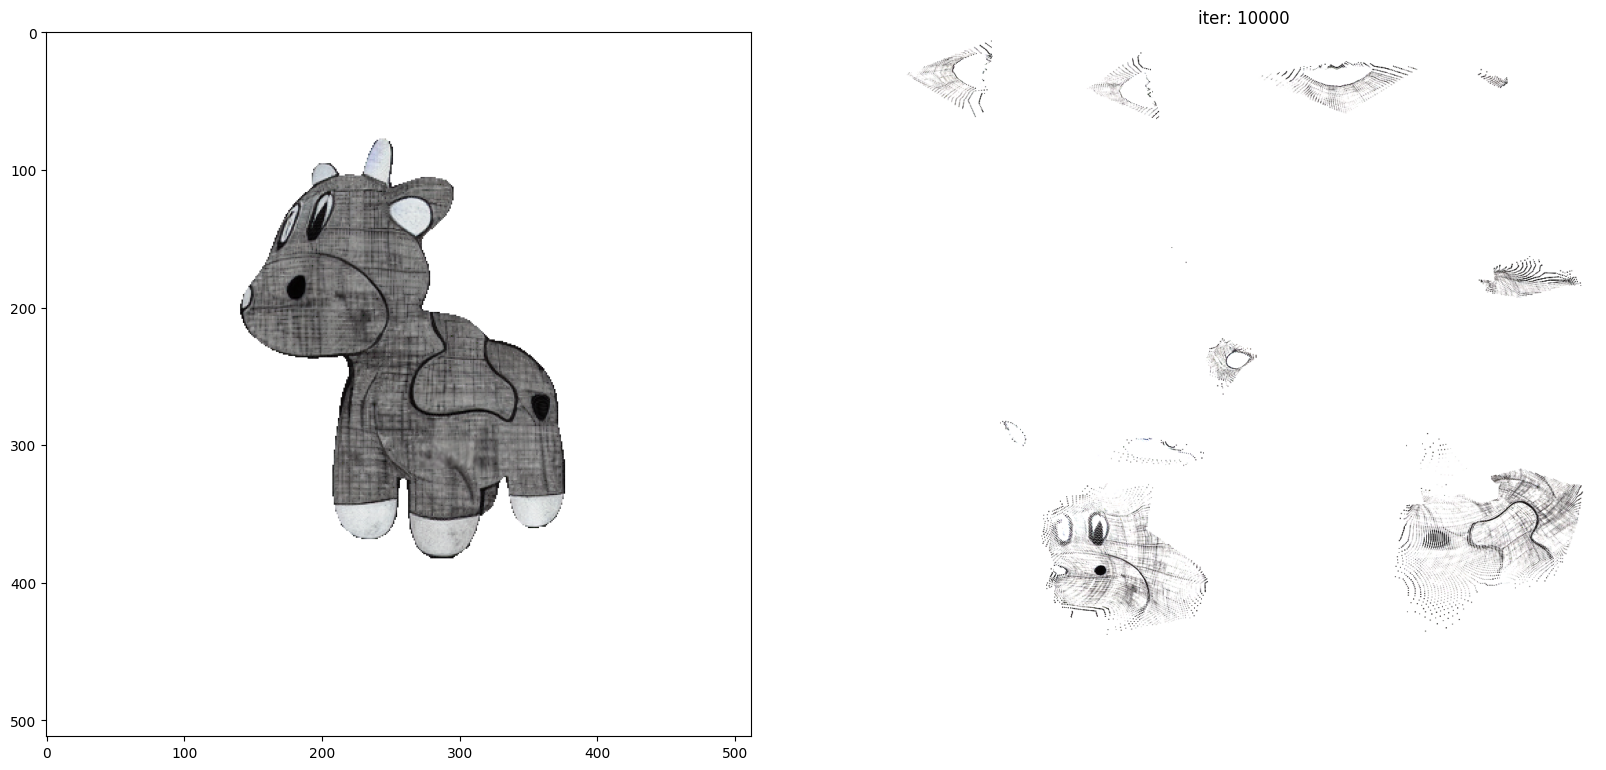

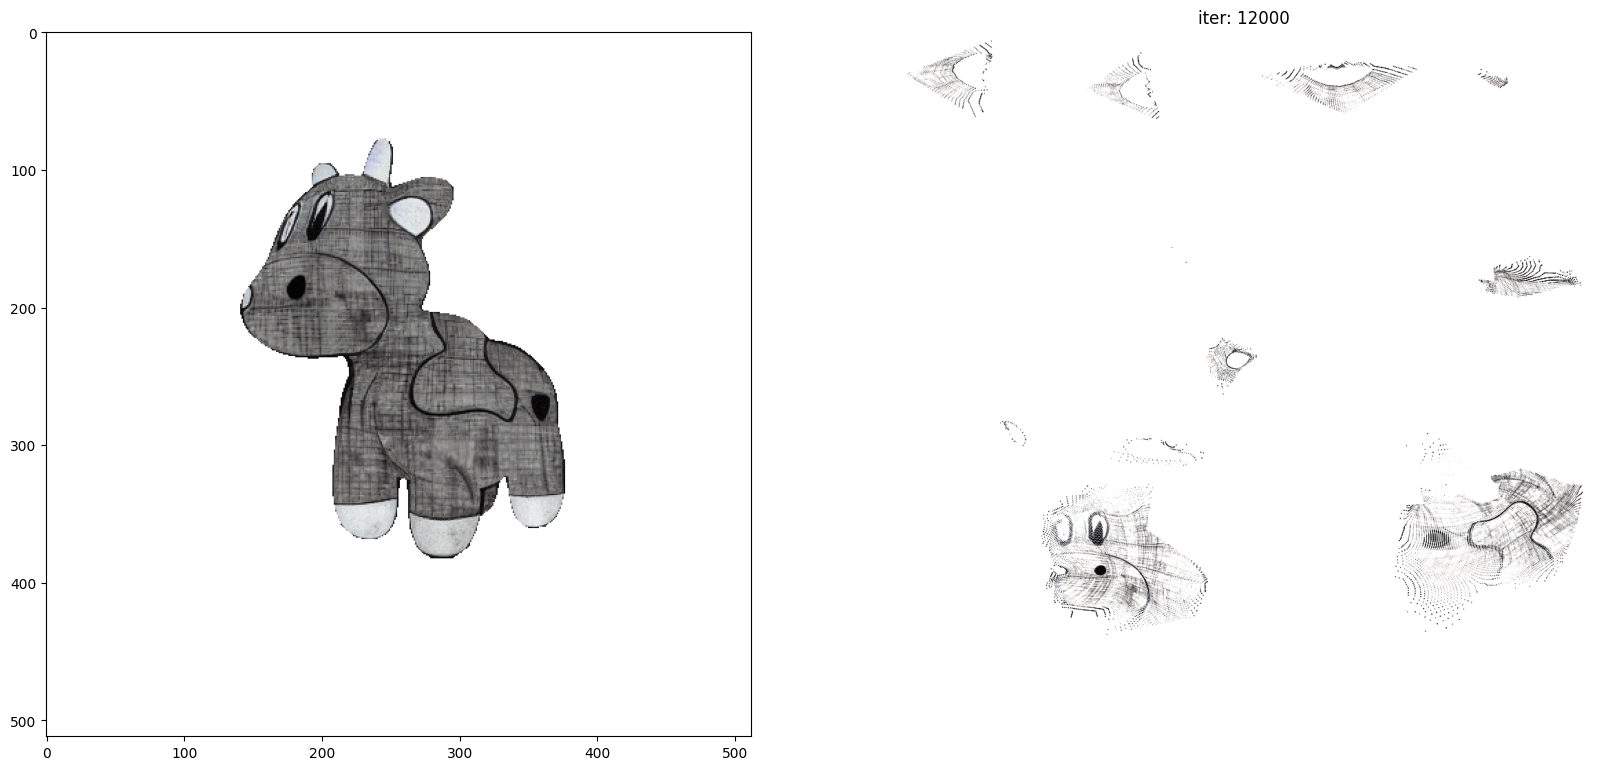

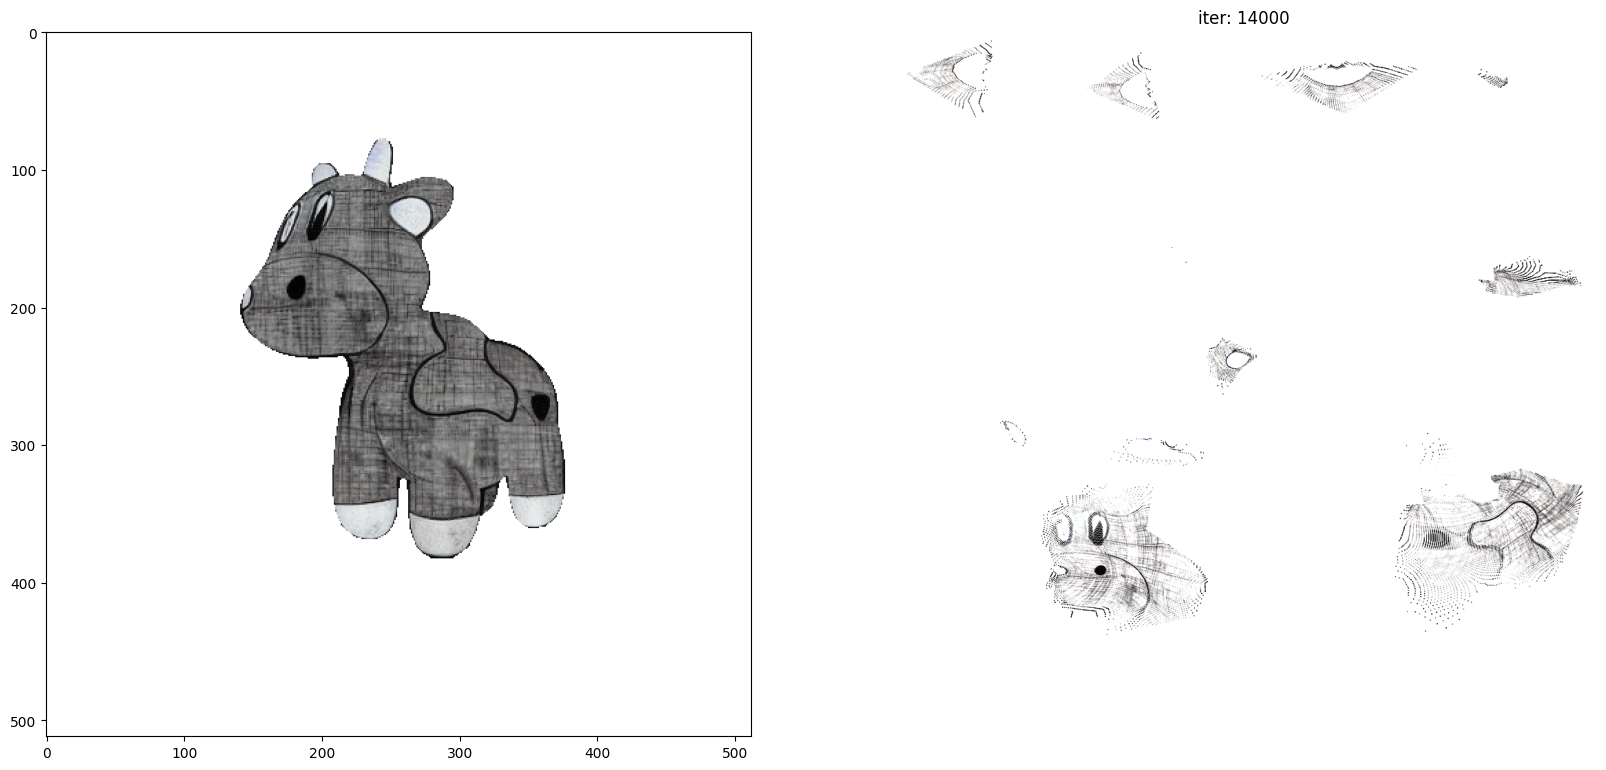

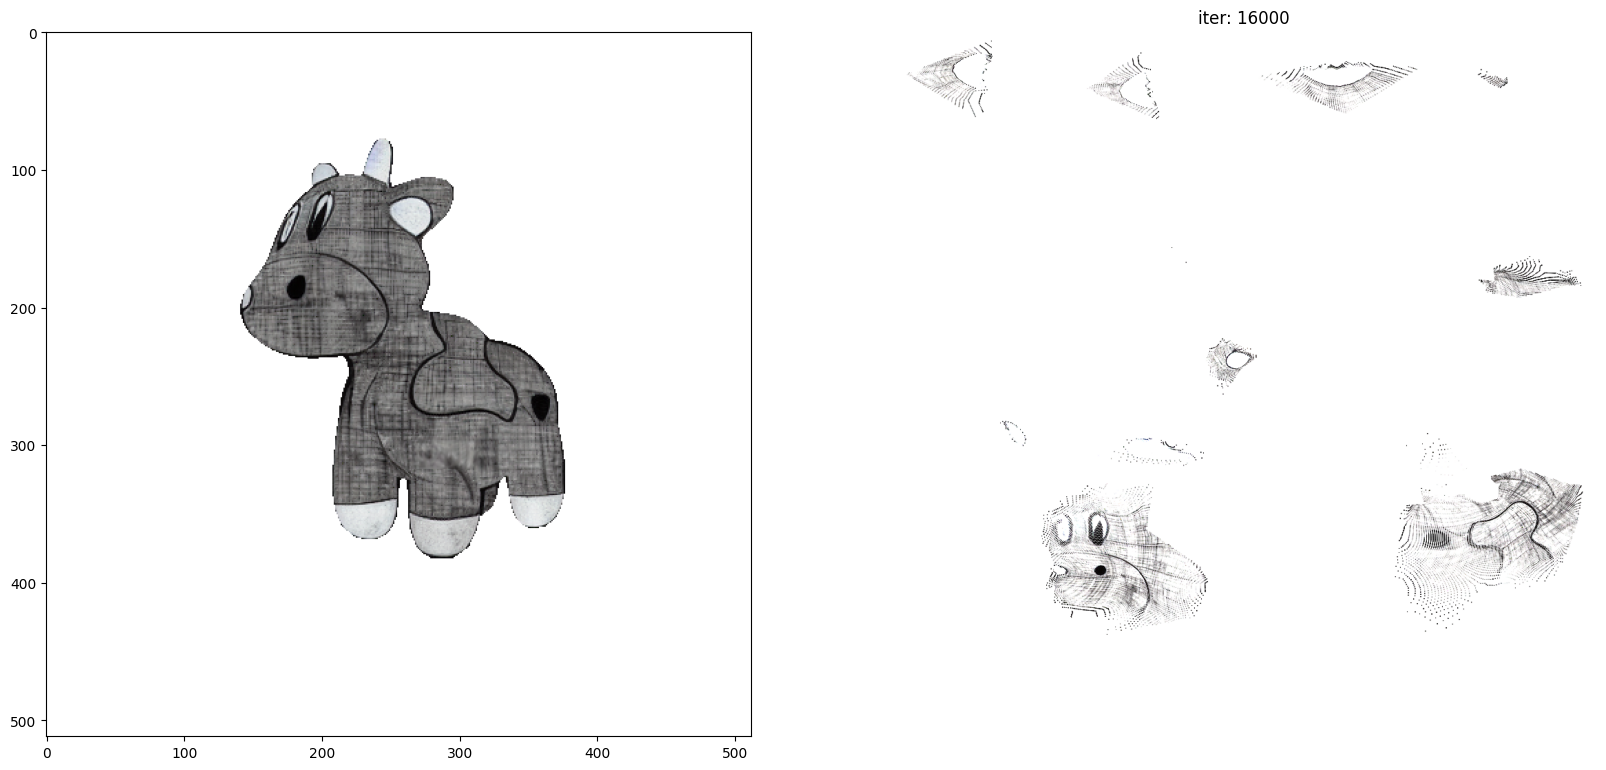

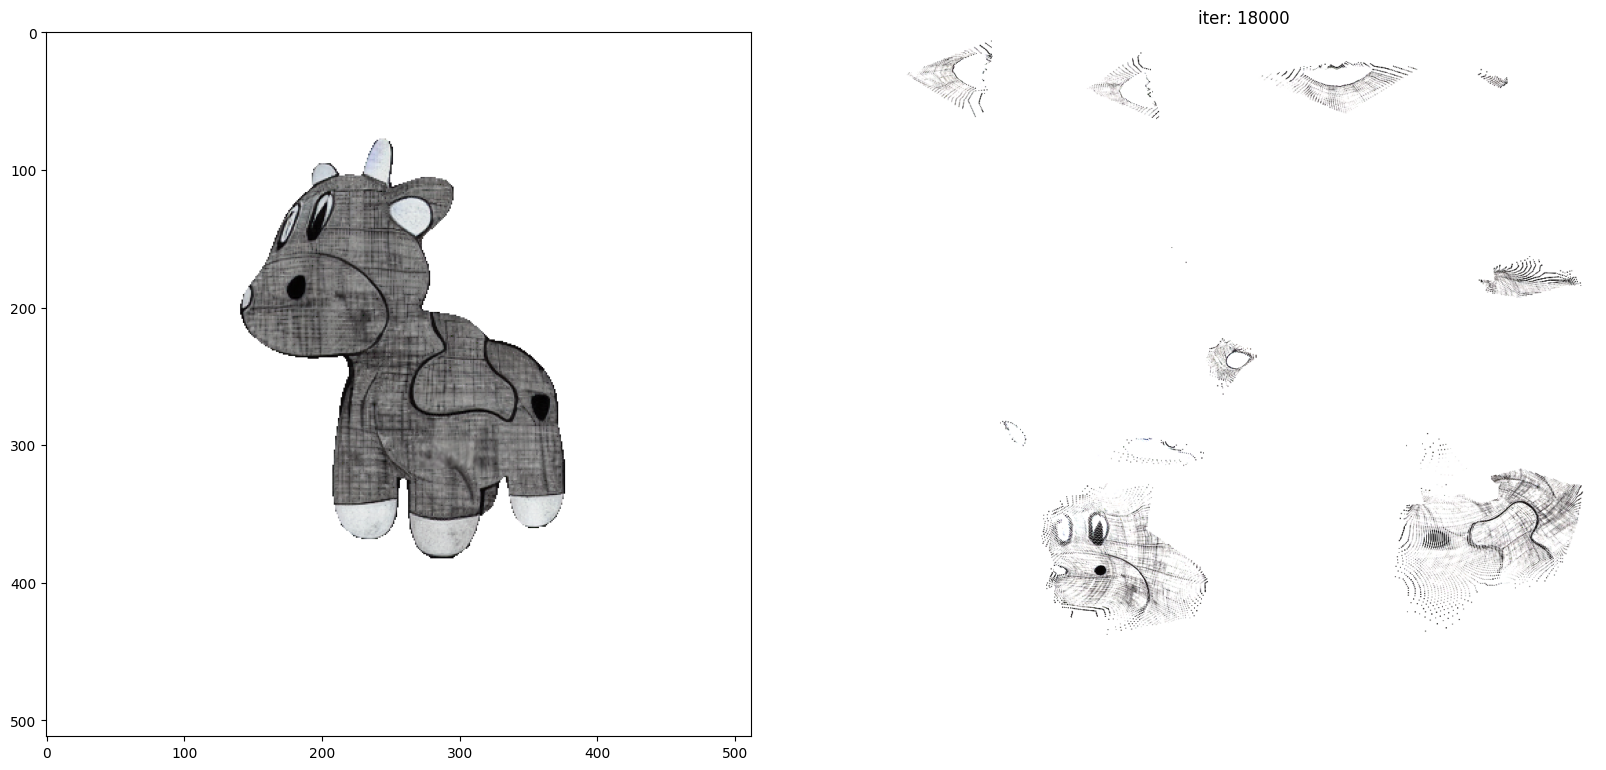

In [32]:
loop = tqdm(range(Niter))

for i in loop:
  # Initialize optimizer
  optimizer.zero_grad()
  # Update the new texture map
  mesh.textures = TexturesUV(maps=[verts_rgb], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])

  # Render the new cow for to compute the new loss and changing RGBA -> RGB
  images_predicted = renderer(mesh, cameras=cameras, lights=lights)
  predicted_rgb = images_predicted[...,:3]

  # Loss Function
  loss_rgb = ((predicted_rgb - target_rgb) ** 2).mean()

  # Visualize the total loss
  loop.set_description("total_loss = %.6f" % loss_rgb)

  # Plot mesh
  if i % plot_period == 0:
    visualize_prediction(mesh, renderer=renderer, title="iter: %d" % i, silhouette=False)

  # Optimization step
  loss_rgb.backward()
  optimizer.step()

In [33]:
#Save the final obj with the new mesh
final_verts, final_faces = mesh.get_mesh_verts_faces(0)
final_obj = "/content/drive/MyDrive/Colab Notebooks/Project_1/cow/final_model.obj"
save_obj(final_obj, final_verts, final_faces)